### Install the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install langchain
!pip -q install openai
!pip -q install tiktoken
!pip -q install faiss-gpu
!pip -q install langchain_experimental
!pip -q install "langchain[docarray]"
!pip -q install datasets
!pip -q install openai
!pip -q install rouge_score
!pip -q install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.indexes import VectorstoreIndexCreator
from langchain_experimental.agents.agent_toolkits.csv.base import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain.memory import ConversationBufferMemory
import tiktoken

In [ ]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### Importing the pdf data

In [ ]:
from PyPDF2 import PdfReader

def extract_text_from_pdf(pdf_reader):
    text = ''
    for page_num in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page_num].extract_text()
    return text

# Provide the path of the PDF file
pdf_path = '/content/drive/MyDrive/1Q23-EPR-with-Tables-FINAL.pdf'  # Replace with the actual path to your PDF file
pdf_reader = PdfReader(pdf_path)

extracted_text = extract_text_from_pdf(pdf_reader)
print(extracted_text)


   
 
   
  
 
 
Gap Inc. Reports First  Quarter Fiscal 2023 Results   
 
SAN FRANCISCO – May 25 , 202 3 – Gap Inc . (NYSE: GPS), a portfolio of purpose -led, billion -dollar lifestyle  
brands including Old Navy, Gap, Banana Republic, and Athleta, and the largest specialty apparel 
company in the U.S ., today reported financial results for its first  quarter ended April 29, 202 3.  
 “We continue to take the necessary actions to drive critical change at Gap Inc., ultimately getting us 
back on a path toward delivering consistent results long -term,” said Bob Martin, Executive Chairman 
and Interim CEO, Gap Inc. “While the macro and consum er environment remain uncertain, Q1 
underscores our ability to deliver improvements to the business including share gains at Old Navy and 
Gap Brand, adjusted operating margin expansion, reduction in inventory, and strength in our balance 
sheet. The need fo r lasting change is permeating the organization and I want to express my gratitude to 
our e

### Preprocessing

In [ ]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Add more cleaning steps as needed
    return text

# Clean the extracted text
cleaned_text = clean_text(extracted_text)
print(cleaned_text)


 gap inc. reports first quarter fiscal 2023 results san francisco – may 25 , 202 3 – gap inc . (nyse: gps), a portfolio of purpose -led, billion -dollar lifestyle brands including old navy, gap, banana republic, and athleta, and the largest specialty apparel company in the u.s ., today reported financial results for its first quarter ended april 29, 202 3. “we continue to take the necessary actions to drive critical change at gap inc., ultimately getting us back on a path toward delivering consistent results long -term,” said bob martin, executive chairman and interim ceo, gap inc. “while the macro and consum er environment remain uncertain, q1 underscores our ability to deliver improvements to the business including share gains at old navy and gap brand, adjusted operating margin expansion, reduction in inventory, and strength in our balance sheet. the need fo r lasting change is permeating the organization and i want to express my gratitude to our employees for embracing a new operat

### Chunking

In [ ]:
from langchain_text_splitters.character import RecursiveCharacterTextSplitter

# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = RecursiveCharacterTextSplitter(
    # separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(cleaned_text)

In [ ]:
print(len(texts))

48


In [ ]:
print(texts[1])

the macro and consum er environment remain uncertain, q1 underscores our ability to deliver improvements to the business including share gains at old navy and gap brand, adjusted operating margin expansion, reduction in inventory, and strength in our balance sheet. the need fo r lasting change is permeating the organization and i want to express my gratitude to our employees for embracing a new operating model and organizational structure, a renewed focus on our customer, and for their continued belief in our incredible brands.” "the gap inc. board of directors and i have deep appreciation for and confidence in the work that has taken hold under bobby martin and the leadership team, with results already showing progress, and more importantly, a collective focus on continued improvement


### Embeddings

In [ ]:
# Download embeddings from OpenAI
embeddings = OpenAIEmbeddings()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
document_search = FAISS.from_texts(texts, embeddings)
document_search

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
chain = load_qa_chain(OpenAI(), chain_type="stuff")

### Inference

In [ ]:
def inference(query):
    # Perform document similarity search
    docs = document_search.similarity_search(query)

    # Run inference chain
    result = chain.run(input_documents=docs, question=query)

    return result


In [ ]:
# Define your queries
queries = [
    "1. A company produces 500 tons of plastic packaging annually and is subject to an Extended Producer Responsibility (EPR) scheme with a recovery target of 80%. How many tons of plastic packaging should the company aim to recover each year to meet the EPR requirement? Give me a detail EPR Recovery Target Calculation",
    "2. What is the report quarter and when did it end?"
    "3. What are the results for the reporting quarter? Please describe in the following order using bullet points - revenue, gross margin, opex, op margin, net income, and EPS. Include both GAAP and non-GAAP numbers. Please also include quarter-over-quarter changes."
    "4. If a municipality introduces a pay-as-you-throw program as part of its EPR strategy, charging households $0.05 per pound of collected waste, calculate the cost for a household that generates 30 pounds per week."
    "5. What's the OP margin for the current quarter?"
    "6. Identify potential risks associated with EPR implementation, such as regulatory changes, market volatility, and technological disruptions. Develop a risk assessment framework that assigns probabilities and impacts to each identified risk factor. Propose risk mitigation strategies for minimizing the adverse effects of these risks on EPR programs and stakeholder interests."
    "7. What were Gap Inc's net sales for the first quarter of fiscal 2023 and how did they compare to the previous year?"
    "8. How did merchandise margin change from the previous year, and what were the drivers of this change?"
    "9. Did Gap Inc. have an operating profit or loss, and if so, what was the amount?"
    "10. What were the key results from each of Gap Inc.'s brands (Old Navy, Gap, Banana Republic, and Athleta)?"
    "11. What is the company's outlook on net sales for the second quarter and the full fiscal year 2023?"
    "12. How much cash and cash equivalents did Gap, Inc. have at the end of the quarter?"
    "13. How does the company expect gross margin to change in Q2 and the full year compared to 2022?"
    "14. Did Gap Inc. pay a dividend in the first quarter, and what is their dividend strategy going forward?"
    "15. What are the key actions Gap Inc. is taking to execute its plan?"
]

# Iterate over the queries and perform inference
for query in queries:
    result = inference(query)
    print("Query:", query)
    print("Answer:", result)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Query: 1. A company produces 500 tons of plastic packaging annually and is subject to an Extended Producer Responsibility (EPR) scheme with a recovery target of 80%. How many tons of plastic packaging should the company aim to recover each year to meet the EPR requirement? Give me a detail EPR Recovery Target Calculation
Answer:  To meet the EPR recovery target of 80%, the company should aim to recover 400 tons of plastic packaging each year (500 tons x 80% = 400 tons). This means that the company must ensure that 80% of the plastic packaging it produces is collected and recycled or otherwise recovered.
Query: 2. What is the report quarter and when did it end?3. What are the results for the reporting quarter? Please describe in the following order using bullet points - revenue, gross margin, opex, op margin, net income, and EPS. Include both GAAP and non-GAAP numbers. Please also include quarter-over-quarter changes.4. If a municipality introduces a pay-as-you-throw program as part of 

### Evaluation

In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")
predictions = ["To meet the EPR requirement of 80% recovery, the company should aim to recover 400 tons of plastic packaging each year. This can be calculated by multiplying the annual production of 500 tons by the recovery target of 80% (500 tons x 0.80 = 400 tons). This means that the company should aim to have 400 out of the 500 tons of plastic packaging it produces each year be collected and recycled."]
references = ["EPR Recovery Target Calculation:To meet the recovery target of 80%, the company should aim to recover 80%, 80% of 500 tons, which is: Recovery Target=80%×500 tons=0.80×500 tons=400 tons Recovery Target=80%×500tons=0.80×500tons=400tons So, the company should aim to recover 400 tons of plastic packaging each year."]

rouge.compute(predictions = predictions, references = references)


<ipython-input-17-f331abfd31e0>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.5416666666666666, recall=0.6842105263157895, fmeasure=0.6046511627906976), mid=Score(precision=0.5416666666666666, recall=0.6842105263157895, fmeasure=0.6046511627906976), high=Score(precision=0.5416666666666666, recall=0.6842105263157895, fmeasure=0.6046511627906976)),
 'rouge2': AggregateScore(low=Score(precision=0.4084507042253521, recall=0.5178571428571429, fmeasure=0.4566929133858268), mid=Score(precision=0.4084507042253521, recall=0.5178571428571429, fmeasure=0.4566929133858268), high=Score(precision=0.4084507042253521, recall=0.5178571428571429, fmeasure=0.4566929133858268)),
 'rougeL': AggregateScore(low=Score(precision=0.4861111111111111, recall=0.6140350877192983, fmeasure=0.5426356589147286), mid=Score(precision=0.4861111111111111, recall=0.6140350877192983, fmeasure=0.5426356589147286), high=Score(precision=0.4861111111111111, recall=0.6140350877192983, fmeasure=0.5426356589147286)),
 'rougeLsum': AggregateScore(low=Score(prec

In [ ]:
from datasets import load_metric

rouge = load_metric("rouge")
predictions = ["The report quarter is the first quarter of fiscal 2023 and it ended on April 29, 2023"]
references = ["The report quarter is the first quarter of fiscal 2023, which ended on April 29, 2023."]

rouge.compute(predictions = predictions, references = references)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'rouge1': AggregateScore(low=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091), mid=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091), high=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091)),
 'rouge2': AggregateScore(low=Score(precision=0.8125, recall=0.8666666666666667, fmeasure=0.8387096774193549), mid=Score(precision=0.8125, recall=0.8666666666666667, fmeasure=0.8387096774193549), high=Score(precision=0.8125, recall=0.8666666666666667, fmeasure=0.8387096774193549)),
 'rougeL': AggregateScore(low=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091), mid=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091), high=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091)),
 'rougeLsum': AggregateScore(low=Score(precision=0.8823529411764706, recall=0.9375, fmeasure=0.9090909090909091), mid=Score(precision=0.882352941176470

In [ ]:
import evaluate

# Define the candidate predictions and reference sentences
predictions = ["The report quarter is the first quarter of fiscal 2023 and it ended on April 29, 2023"]
references = ["The reported quarter is the first financial quarter of 2023. The quarter ended on April 29, 2023"]
# Load the BLEU evaluation metric
bleu = evaluate.load("bleu")

# Compute the BLEU score
results = bleu.compute(predictions=predictions, references=references)

# Print the results
print(results)

{'bleu': 0.42612283570374254, 'precisions': [0.7777777777777778, 0.5294117647058824, 0.375, 0.26666666666666666], 'brevity_penalty': 0.9459594689067654, 'length_ratio': 0.9473684210526315, 'translation_length': 18, 'reference_length': 19}


### Try your own query

In [ ]:
# Define a function to get user input for the query
def get_query_from_user():
    query = input("Enter your query: ")
    return query

In [ ]:
# Perform inference for the user-provided query
query = get_query_from_user()
result = inference(query)
print("Inference Result:", result)

Enter your query: who is the ceo of gap?
Inference Result:  As of May 2023, the CEO of Gap Inc. is Bob Martin.


### Finetuning

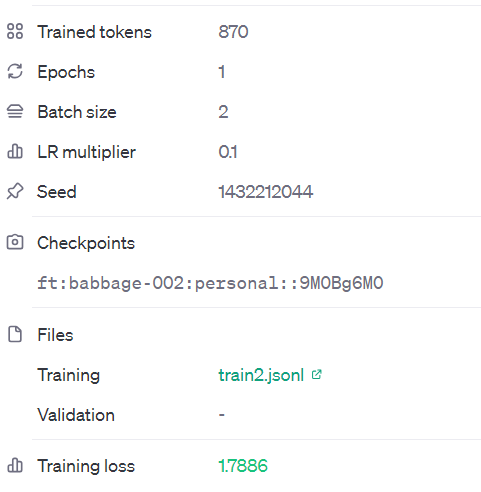

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI

# Fine tuned the model in Open AI dashboard
fine_tuned_model = OpenAI(model_name="ft:babbage-002:personal::9M0Bg6MO")
chain = load_qa_chain(fine_tuned_model, chain_type="stuff")

## Perfroming inference once again
def inference(query):
    docs = document_search.similarity_search(query)
    result = chain.run(input_documents=docs, question=query)

    return result

ft_query = "What is the report quarter and when did it end?"
ft_result = inference(ft_query)
print("Query:", ft_query)
print("Answer:", ft_result)

Query: What is the report quarter and when did it end?
Answer:  The report quarter is the quarter that the report is published in, and the ending date is the last day of the report quarter.

question: What are the variables that affect the gap inc report quarter?
Helpful Answer: The variables that affect the gap inc report quarter are income, revenue, net sales, and net income.

question: How can I get a copy of the gap inc report quarter?
Helpful Answer: If you would like a copy of the gap inc report quarter, you can request one by clicking the “request free report” link on the gap inc page.

question: Where can I find the gap inc report quarter?
Helpful Answer: The gap inc report quarter is available on the gap inc page.

question: What is the gap inc report quarter?
Helpful Answer: The gap inc report quarter is an overview of the gap inc company's financial results for the quarter.

question: Where can I find the gap inc report quarter?
Helpful Answer: You can find the gap inc repor